In [21]:
!pip install pandas
!pip install seaborn
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, to_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DoubleType
from pyspark.ml.evaluation import RegressionEvaluator
import folium
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
import pandas as pd






In [22]:
from pyspark.sql import SparkSession

# Step 1: Create SparkSession
spark = SparkSession.builder \
    .appName("/content/yellow_tripdata_2020-01.csv") \
    .getOrCreate()




root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+-

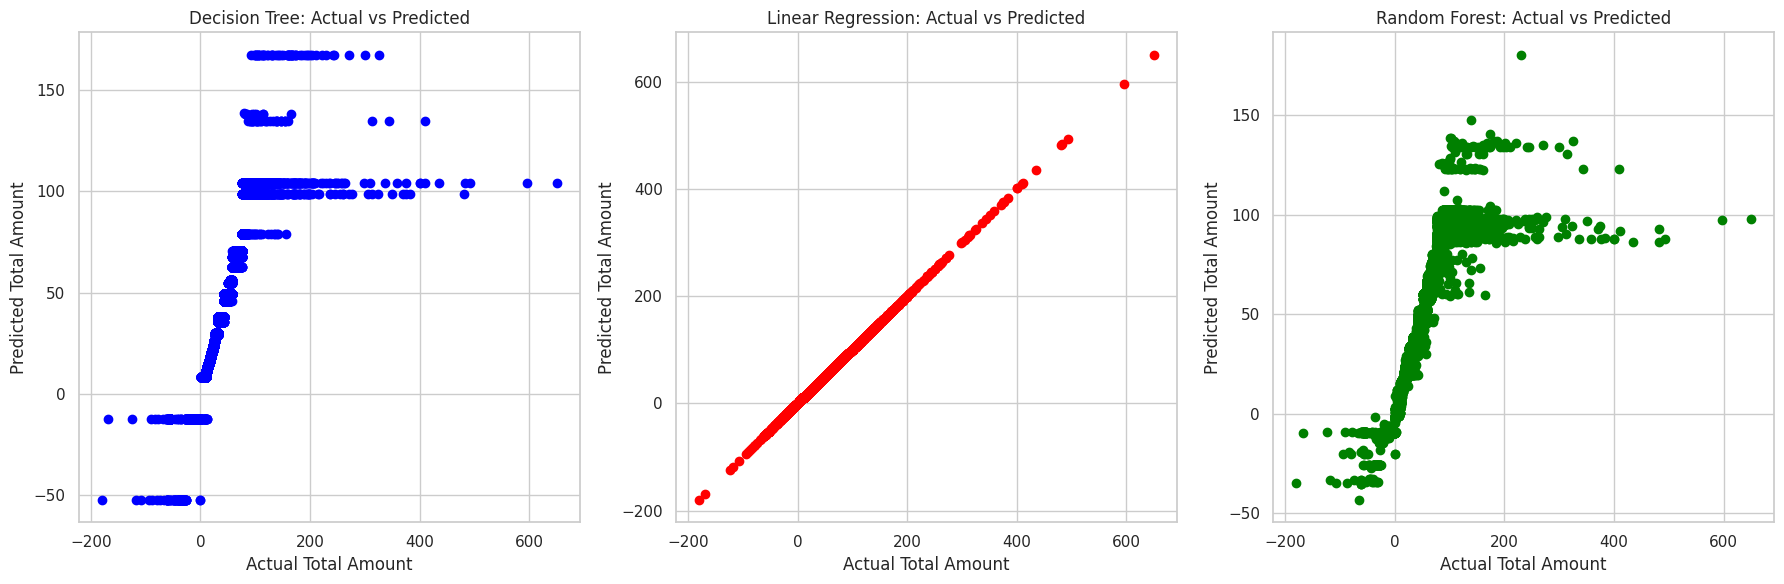

Decision Tree RMSE: 3.956666956089354
Linear Regression RMSE: 3.0262566712175415e-14
Random Forest RMSE: 4.10418551773734


In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType  # Import DoubleType

import pandas as pd

# Create a SparkSession
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .getOrCreate()

# Read the dataset into a PySpark DataFrame
spark_df = spark.read.csv("/content/yellow_tripdata_2020-01.csv", header=True)

# Drop rows with missing values
spark_df = spark_df.dropna()


# Display basic information about the dataset
spark_df.printSchema()

# Check for missing values
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

# Drop rows with missing values
spark_df = spark_df.dropna()


# Check for duplicates
print("Number of duplicate rows:", spark_df.count() - spark_df.dropDuplicates().count())


# Convert string columns to double type
feature_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
for col_name in feature_columns:
    spark_df = spark_df.withColumn(col_name, spark_df[col_name].cast(DoubleType()))

# Convert string columns to double type
feature_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
for col_name in feature_columns:
    spark_df = spark_df.withColumn(col_name, spark_df[col_name].cast("double"))
    # Display DataFrame
spark_df.show()


print(spark_df.head(10))


# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
clean_spark_df = assembler.transform(spark_df)

# Split the data into train and test sets
(train_data, test_data) = clean_spark_df.randomSplit([0.7, 0.3], seed=42)

# Train Decision Tree model
decision_tree = DecisionTreeRegressor(featuresCol="features", labelCol="total_amount", seed=42)
decision_tree_model = decision_tree.fit(train_data)

# Train Linear Regression model
linear_reg = LinearRegression(featuresCol="features", labelCol="total_amount")
linear_reg_model = linear_reg.fit(train_data)

# Train Random Forest model
random_forest = RandomForestRegressor(featuresCol="features", labelCol="total_amount", seed=42)
random_forest_model = random_forest.fit(train_data)

# Make predictions
decision_tree_pred = decision_tree_model.transform(test_data).select("total_amount", "prediction")
linear_reg_pred = linear_reg_model.transform(test_data).select("total_amount", "prediction")
random_forest_pred = random_forest_model.transform(test_data).select("total_amount", "prediction")

# Convert Spark DataFrame predictions to Pandas DataFrame
decision_tree_pred_pd = decision_tree_pred.toPandas()
linear_reg_pred_pd = linear_reg_pred.toPandas()
random_forest_pred_pd = random_forest_pred.toPandas()

# Plotting the predictions
plt.figure(figsize=(18, 6))

# Decision Tree: Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(decision_tree_pred_pd["total_amount"], decision_tree_pred_pd["prediction"], color="blue")
plt.title("Decision Tree: Actual vs Predicted")
plt.xlabel("Actual Total Amount")
plt.ylabel("Predicted Total Amount")

# Linear Regression: Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(linear_reg_pred_pd["total_amount"], linear_reg_pred_pd["prediction"], color="red")
plt.title("Linear Regression: Actual vs Predicted")
plt.xlabel("Actual Total Amount")
plt.ylabel("Predicted Total Amount")

# Random Forest: Actual vs Predicted
plt.subplot(1, 3, 3)
plt.scatter(random_forest_pred_pd["total_amount"], random_forest_pred_pd["prediction"], color="green")
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Actual Total Amount")
plt.ylabel("Predicted Total Amount")

plt.tight_layout()
plt.show()




# Evaluate models
evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")

decision_tree_rmse = evaluator.evaluate(decision_tree_pred)
linear_reg_rmse = evaluator.evaluate(linear_reg_pred)
random_forest_rmse = evaluator.evaluate(random_forest_pred)

# Print RMSE for each model
print("Decision Tree RMSE:", decision_tree_rmse)
print("Linear Regression RMSE:", linear_reg_rmse)
print("Random Forest RMSE:", random_forest_rmse)



root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+-

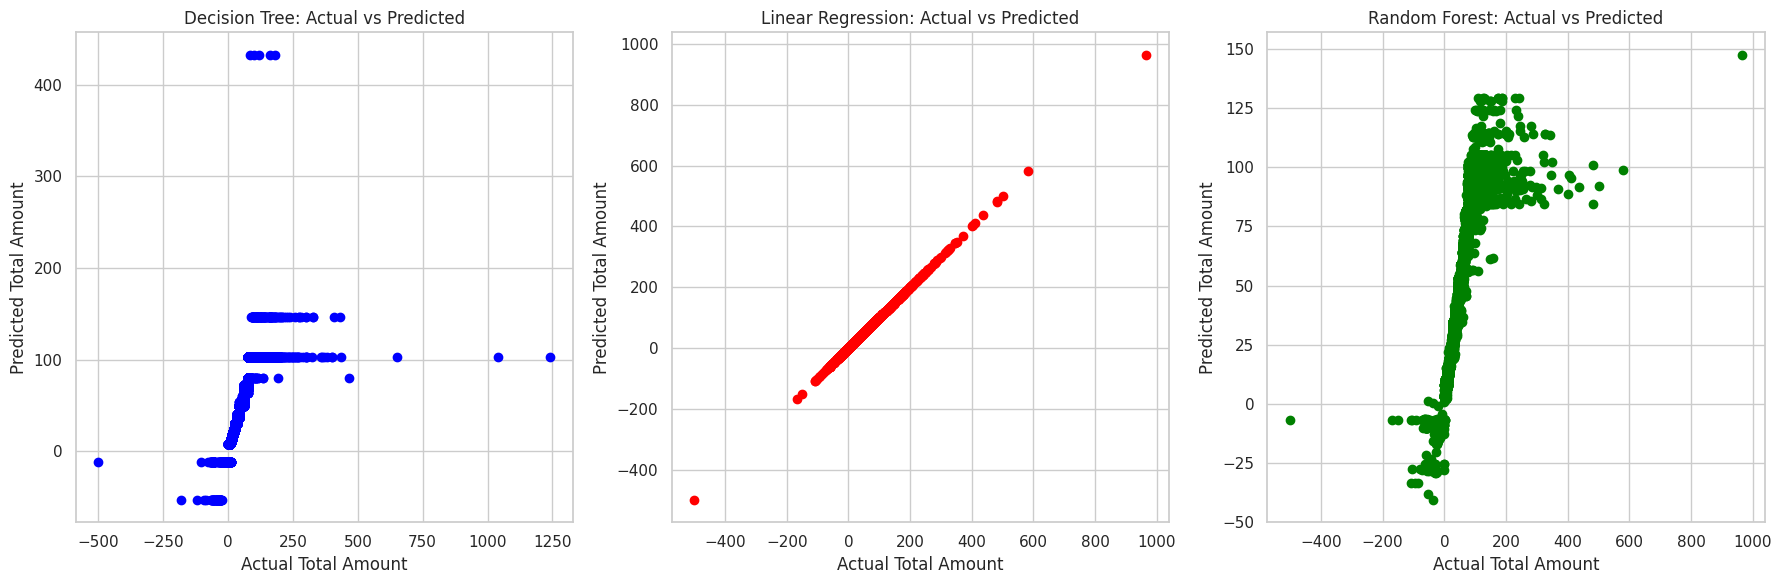

Decision Tree RMSE: 4.006990875777319
Linear Regression RMSE: 1.8813212529204172e-15
Random Forest RMSE: 4.256922059109648


In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType  # Import DoubleType

# Create a SparkSession
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .getOrCreate()

# Read the dataset into a PySpark DataFrame
spark_df = spark.read.csv("/content/yellow_tripdata_2020-01.csv", header=True)

# Drop rows with missing values
spark_df = spark_df.dropna()

# Display basic information about the dataset
spark_df.printSchema()

# Check for missing values
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

# Drop duplicates
spark_df = spark_df.dropDuplicates()

# Convert string columns to double type
feature_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
for col_name in feature_columns:
    spark_df = spark_df.withColumn(col_name, spark_df[col_name].cast(DoubleType()))

# Convert string columns to double type
feature_columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
for col_name in feature_columns:
    spark_df = spark_df.withColumn(col_name, spark_df[col_name].cast("double"))
    # Display DataFrame
spark_df.show()

# Save the clean Spark DataFrame to a CSV file
clean_data_path = "/content/clean_yellow_tripdata.csv"
spark_df.write.csv(clean_data_path, header=True)



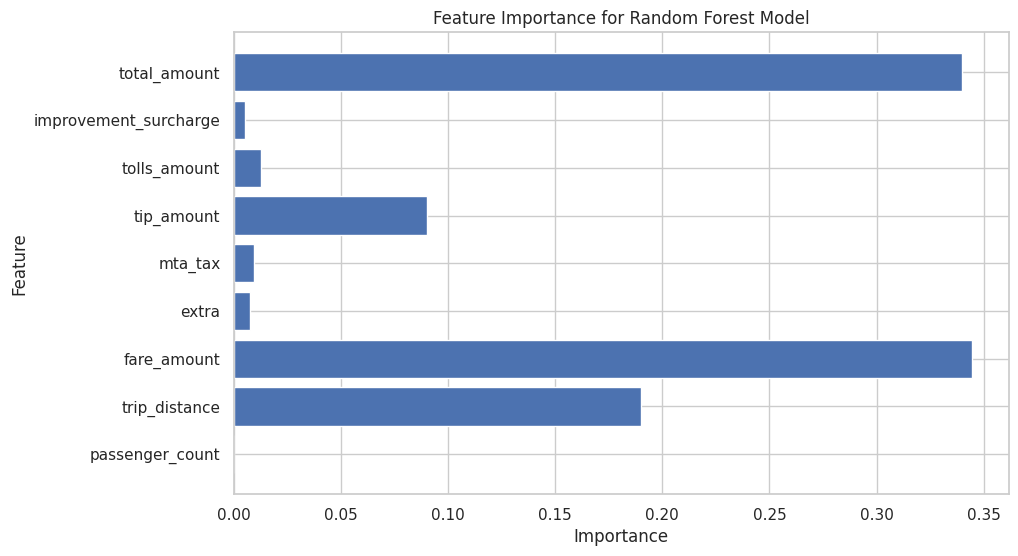

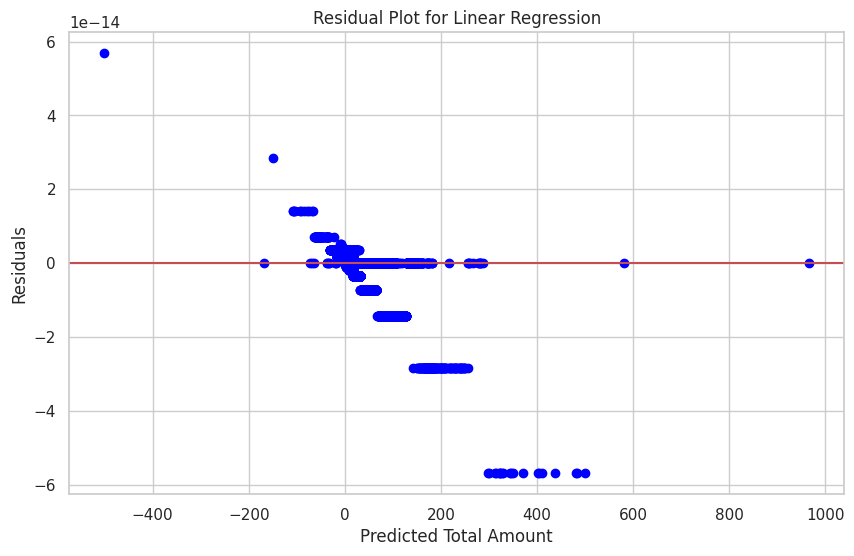

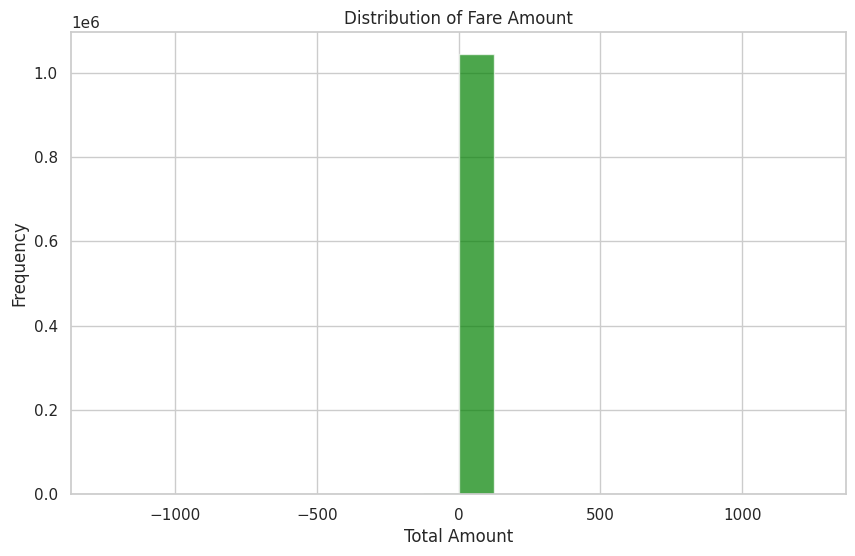

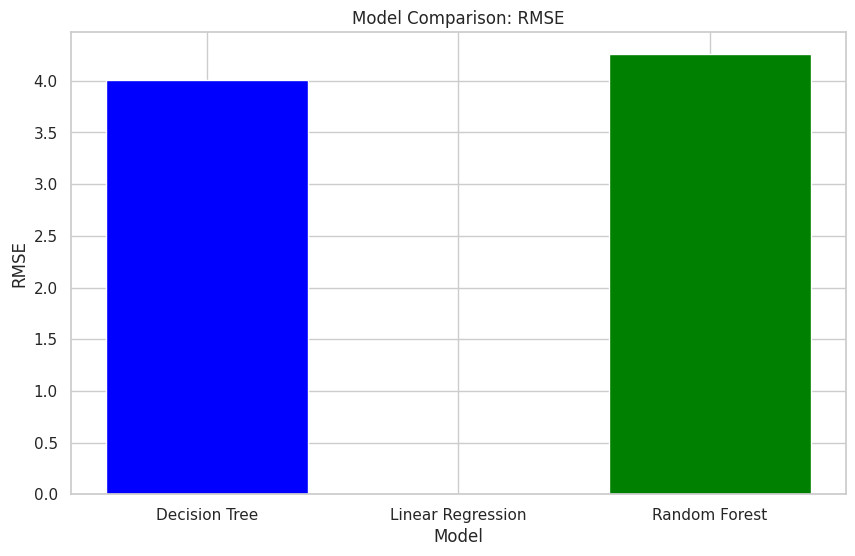

In [44]:
# Feature Importance Plot for Random Forest
importances = random_forest_model.featureImportances.toArray()
plt.figure(figsize=(10, 6))
plt.barh(feature_columns, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.show()

# Residual Plot for Linear Regression
linear_reg_residuals = linear_reg_pred_pd["total_amount"] - linear_reg_pred_pd["prediction"]
plt.figure(figsize=(10, 6))
plt.scatter(linear_reg_pred_pd["prediction"], linear_reg_residuals, color='blue')
plt.xlabel('Predicted Total Amount')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linear Regression')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Distribution of Fare Amount
plt.figure(figsize=(10, 6))
plt.hist(spark_df.select("total_amount").rdd.flatMap(lambda x: x).collect(), bins=20, color='green', alpha=0.7)
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Fare Amount')
plt.show()

# Model Comparison Bar Chart
models = ['Decision Tree', 'Linear Regression', 'Random Forest']
rmse_values = [decision_tree_rmse, linear_reg_rmse, random_forest_rmse]
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'red', 'green'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison: RMSE')
plt.show()


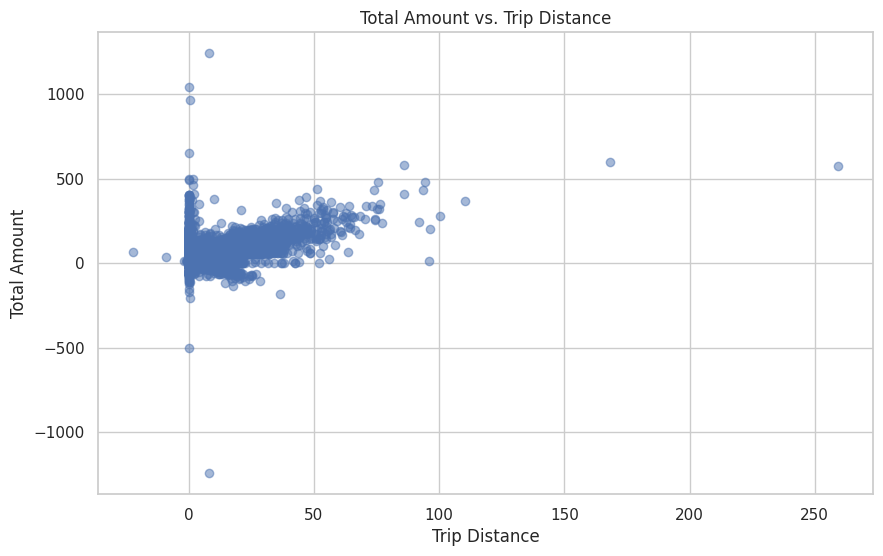

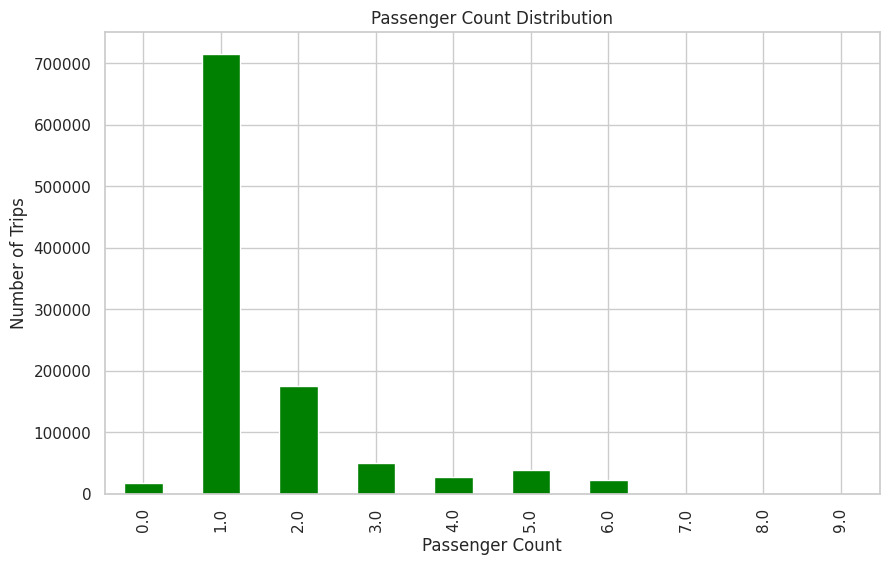

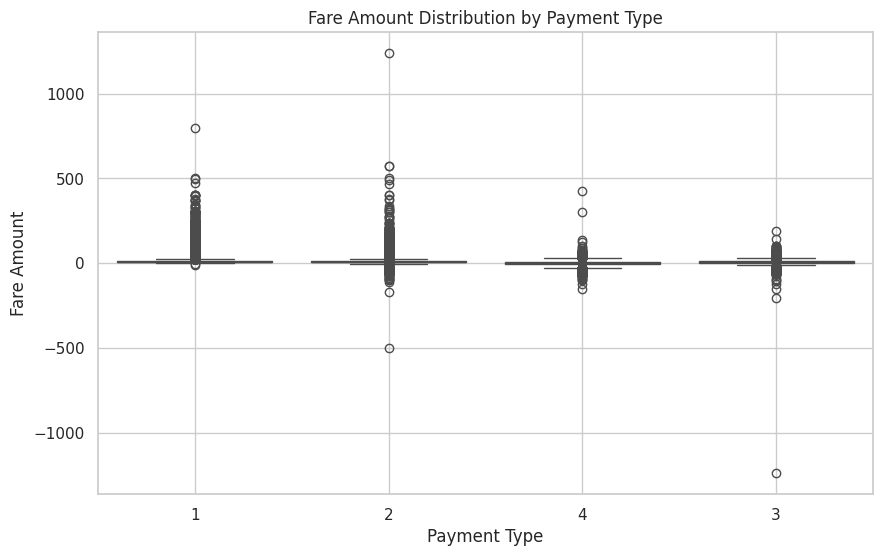

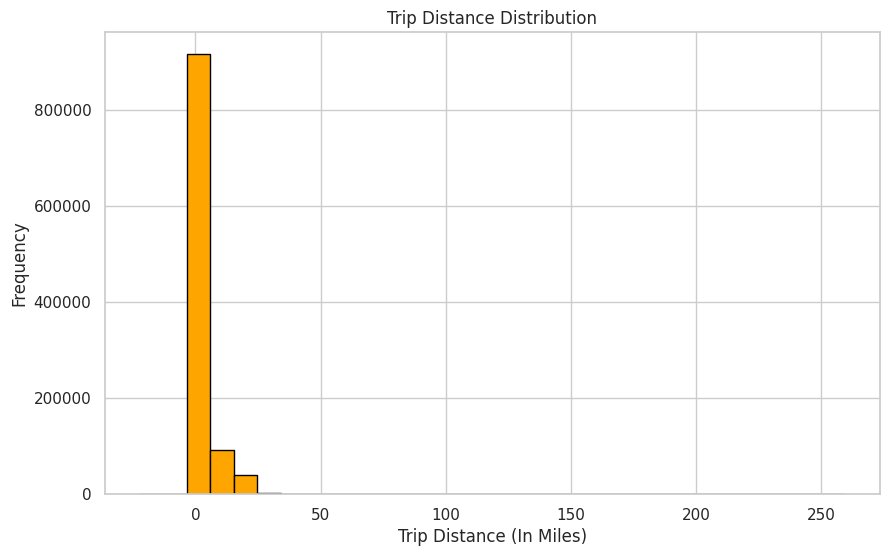

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()


# 2. Scatter Plot - Total Amount vs. Trip Distance
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['trip_distance'], pandas_df['total_amount'], alpha=0.5)
plt.title('Total Amount vs. Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

# 3. Bar Chart - Passenger Count Distribution
passenger_count_distribution = pandas_df['passenger_count'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
passenger_count_distribution.plot(kind='bar', color='green')
plt.title('Passenger Count Distribution')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

# 4. Box Plot - Fare Amount Distribution by Payment Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_type', y='fare_amount', data=pandas_df)
plt.title('Fare Amount Distribution by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Fare Amount')
plt.grid(True)
plt.show()

# 5. Histogram - Trip Distance Distribution
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['trip_distance'], bins=30, color='orange', edgecolor='black')
plt.title('Trip Distance Distribution')
plt.xlabel('Trip Distance (In Miles)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



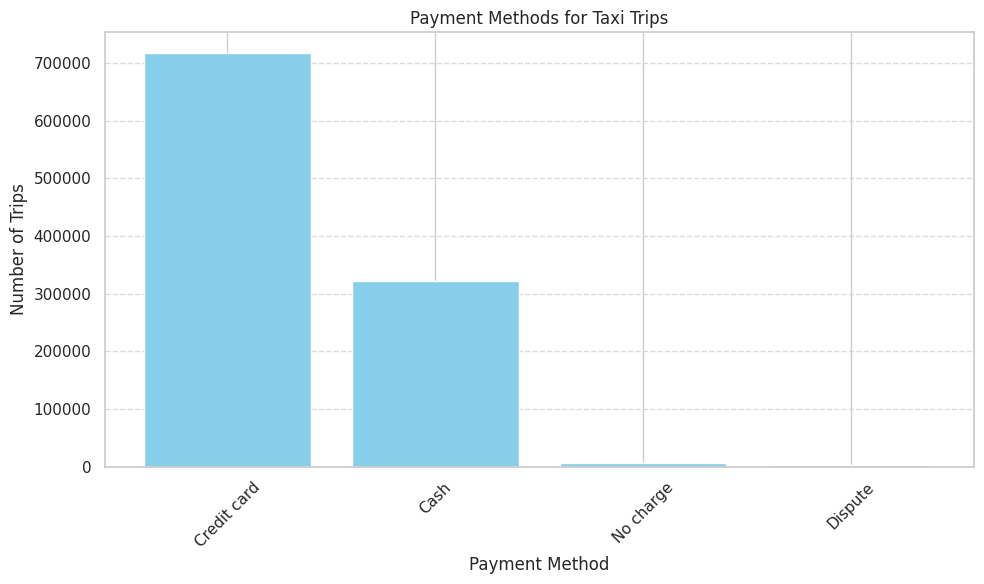

In [40]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Create a SparkSession
spark = SparkSession.builder \
    .appName("PaymentMethodsAnalysis") \
    .getOrCreate()

# Load the dataset into a Spark DataFrame
df_spark = spark.read.csv("/content/yellow_tripdata_2020-01.csv", header=True)

# Count the occurrences of each payment type
payment_counts = df_spark.groupBy('payment_type').count().orderBy('count', ascending=False)

# Map numeric payment codes to corresponding labels
payment_labels = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided trip'
}

# Convert payment type column to string and perform replacement
payment_counts = payment_counts.withColumn('payment_type', col('payment_type').cast('string'))
for code, label in payment_labels.items():
    payment_counts = payment_counts.withColumn('payment_type', when(col('payment_type') == str(code), label).otherwise(col('payment_type')))

# Convert Spark DataFrame to Pandas DataFrame for plotting
payment_counts_pd = payment_counts.toPandas()

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(payment_counts_pd['payment_type'], payment_counts_pd['count'], color='skyblue')
plt.title('Payment Methods for Taxi Trips')
plt.xlabel('Payment Method')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<ipython-input-25-f453e6280207>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_fares_by_day.index, y=average_fares_by_day.values, palette="viridis")


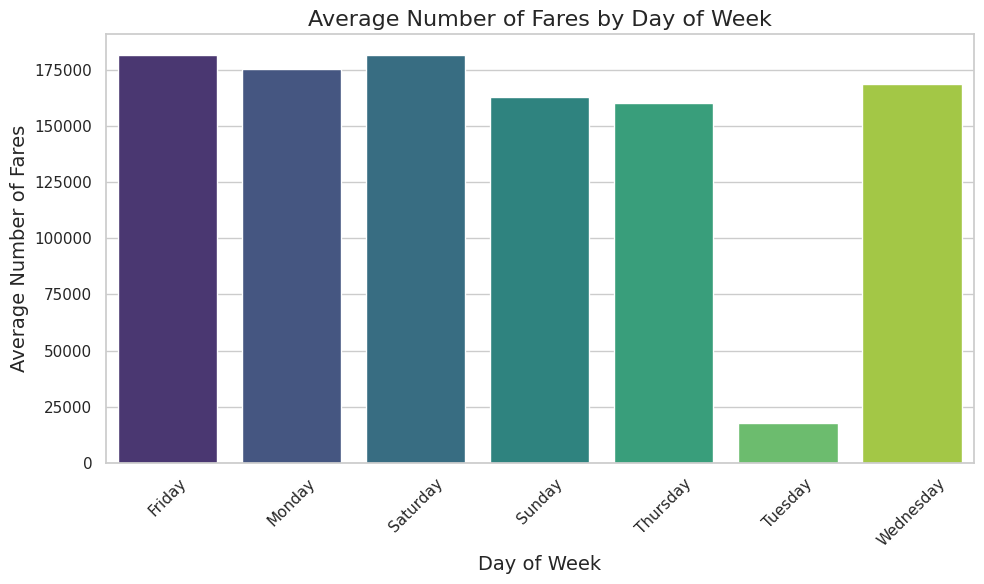

<ipython-input-25-f453e6280207>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_fare_by_week.index, y=average_fare_by_week.values, palette="magma")


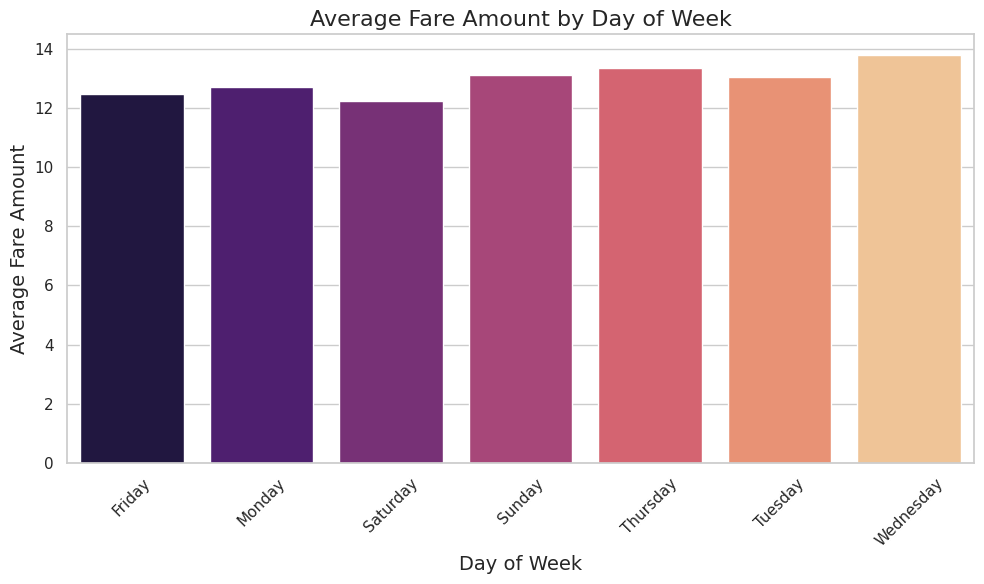

<ipython-input-25-f453e6280207>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_distance_by_week.index, y=average_distance_by_week.values, palette="rocket")


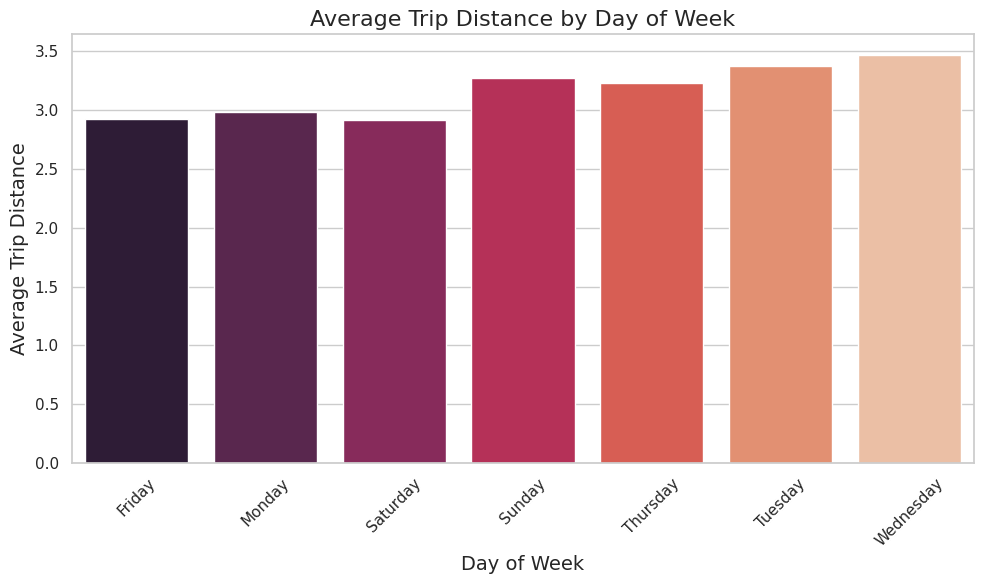

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spark_df is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()

# Parse datetime column
pandas_df['tpep_pickup_datetime'] = pd.to_datetime(pandas_df['tpep_pickup_datetime'], format='%d-%m-%Y %H:%M')

# Extract day of week
pandas_df['day_of_week'] = pandas_df['tpep_pickup_datetime'].dt.day_name()

# Set seaborn style
sns.set(style="whitegrid")

# Plot 1: Average number of fares by day of week
plt.figure(figsize=(10, 6))
average_fares_by_day = pandas_df.groupby('day_of_week')['fare_amount'].count()
sns.barplot(x=average_fares_by_day.index, y=average_fares_by_day.values, palette="viridis")
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Number of Fares', fontsize=14)
plt.title('Average Number of Fares by Day of Week', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Average fare amount by day of week
plt.figure(figsize=(10, 6))
average_fare_by_week = pandas_df.groupby('day_of_week')['fare_amount'].mean()
sns.barplot(x=average_fare_by_week.index, y=average_fare_by_week.values, palette="magma")
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Fare Amount', fontsize=14)
plt.title('Average Fare Amount by Day of Week', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 3: Average distance by day of week
plt.figure(figsize=(10, 6))
average_distance_by_week = pandas_df.groupby('day_of_week')['trip_distance'].mean()
sns.barplot(x=average_distance_by_week.index, y=average_distance_by_week.values, palette="rocket")
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Trip Distance', fontsize=14)
plt.title('Average Trip Distance by Day of Week', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




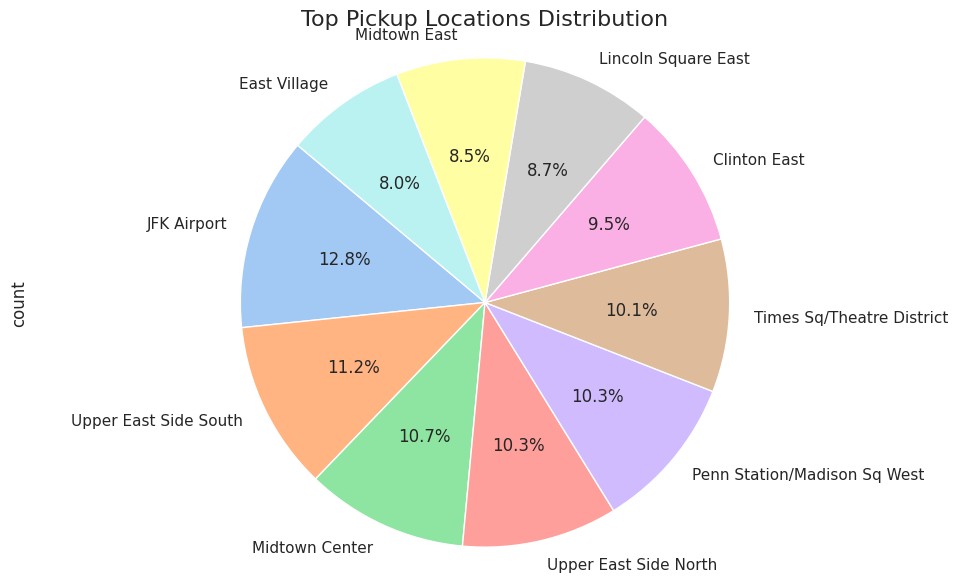

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming spark_df is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = spark_df.toPandas()

# Parse datetime column
pandas_df['tpep_pickup_datetime'] = pd.to_datetime(pandas_df['tpep_pickup_datetime'], format='%d-%m-%Y %H:%M')

# Extract day of week
pandas_df['day_of_week'] = pandas_df['tpep_pickup_datetime'].dt.day_name()

# Set seaborn style
sns.set(style="whitegrid")

# Load the taxizone lookup data
taxi_zone_data = pd.read_csv("/content/taxi+_zone_lookup.csv")

# Convert PULocationID column to int64 to match LocationID data type
pandas_df['PULocationID'] = pandas_df['PULocationID'].astype(int)

# Join taxi zone data with pandas_df on PULocationID
pandas_df = pandas_df.merge(taxi_zone_data[['LocationID', 'Zone']], left_on='PULocationID', right_on='LocationID')

# Plot 4: Pickup location distribution (top 10)
plt.figure(figsize=(10, 6))
top_pickup_locations = pandas_df['Zone'].value_counts().head(10)
top_pickup_locations.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=140)
plt.title('Top Pickup Locations Distribution', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()





In [34]:
import folium

# Define a function to retrieve coordinates from location ID
def get_coordinates_from_location_id(location_id):
    # Replace this with your own logic to retrieve coordinates from location ID
    # Example: location_id_to_coordinates = {...}
    # return location_id_to_coordinates.get(location_id)
    pass

# Create a map centered around New York City
map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add markers for pickup and dropoff locations to the map
for row in df_spark.collect():
    pickup_coordinates = get_coordinates_from_location_id(row['PULocationID'])
    dropoff_coordinates = get_coordinates_from_location_id(row['DOLocationID'])

    if pickup_coordinates is not None:
        # Add a marker for pickup location with ID as label
        folium.Marker(location=pickup_coordinates, popup=f"Pickup Location ID: {row['PULocationID']}").add_to(map)

    if dropoff_coordinates is not None:
        # Add a marker for dropoff location with ID as label
        folium.Marker(location=dropoff_coordinates, popup=f"Dropoff Location ID: {row['DOLocationID']}").add_to(map)

# Save the map to an HTML file
map.save("map_with_location_ids.html")

# Display the HTML file in the notebook using an iframe
from IPython.display import IFrame
IFrame(src='map_with_location_ids.html', width=700, height=600)


In [36]:
import pandas as pd
import folium

# Load the dataset
data = pd.read_csv("/content/yellow_tripdata_2020-01.csv")

# Calculate the most popular pickup and dropoff locations
most_popular_pickup = data['PULocationID'].value_counts().idxmax()
most_popular_dropoff = data['DOLocationID'].value_counts().idxmax()

# Define a function to retrieve coordinates from location ID
def get_coordinates_from_location_id(location_id):
    # Replace this with your own logic to retrieve coordinates from location ID
    # Example: location_id_to_coordinates = {...}
    # return location_id_to_coordinates.get(location_id)
    pass

# Create a map centered around New York City
map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add markers for pickup and dropoff locations to the map
for index, row in data.iterrows():
    pickup_coordinates = get_coordinates_from_location_id(row['PULocationID'])
    dropoff_coordinates = get_coordinates_from_location_id(row['DOLocationID'])

    if pickup_coordinates is not None:
        # Add a marker for pickup location with ID as label
        folium.Marker(location=pickup_coordinates, popup=f"Pickup Location ID: {row['PULocationID']}").add_to(map)

    if dropoff_coordinates is not None:
        # Add a marker for dropoff location with ID as label
        folium.Marker(location=dropoff_coordinates, popup=f"Dropoff Location ID: {row['DOLocationID']}").add_to(map)

# Highlight the most popular pickup location
if get_coordinates_from_location_id(most_popular_pickup) is not None:
    folium.Marker(location=get_coordinates_from_location_id(most_popular_pickup),
                  popup=f"Most Popular Pickup Location ID: {most_popular_pickup}",
                  icon=folium.Icon(color='green')).add_to(map)

# Highlight the most popular dropoff location
if get_coordinates_from_location_id(most_popular_dropoff) is not None:
    folium.Marker(location=get_coordinates_from_location_id(most_popular_dropoff),
                  popup=f"Most Popular Dropoff Location ID: {most_popular_dropoff}",
                  icon=folium.Icon(color='red')).add_to(map)

# Save the map to an HTML file
map.save("map_with_popular_locations.html")

# Display the HTML file in the notebook using an iframe
from IPython.display import IFrame
IFrame(src='map_with_popular_locations.html', width=700, height=600)
